<a href="https://colab.research.google.com/github/CS7140/PA-2/blob/master/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting Gumbel Distribution Constants via Gradient Descent and AutoDiff

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics as st
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
def generateGumbelDistribution(alpha_loc, beta_scale, n_numDataPoints):
    return tf.convert_to_tensor(np.random.gumbel(loc=alpha_loc, scale=beta_scale, size=n_numDataPoints), dtype=tf.float32)

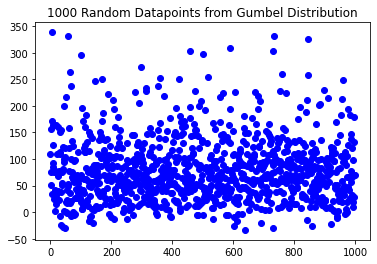

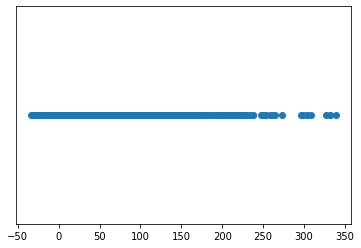

In [3]:
n_numDataPoints = 1000
alpha_loc = 50 # real number
beta_scale = 45  # beta > 0

gumbelDist = generateGumbelDistribution(alpha_loc,beta_scale,n_numDataPoints)

plt.plot(gumbelDist, 'bo')
plt.title(str(n_numDataPoints) + " Random Datapoints from Gumbel Distribution")
plt.show()

plt.scatter(gumbelDist, np.zeros_like(gumbelDist))
plt.yticks([])
plt.show()

In [4]:
def p(x, alphaBeta):
    alpha = alphaBeta[0][0]
    beta = alphaBeta[1][0]

    p = 1/beta * tf.math.exp(-1*(x-alpha)/beta) * tf.math.exp(-1*tf.math.exp(-1*(x-alpha)/beta))
    return p

def logLikelihoodP(x,alphaBeta):
    return tf.math.reduce_sum(tf.math.log(p(x,alphaBeta)))

In [5]:
def estimateGumbelAlphaBeta(gumbelDist, learningRate = 0.5, verbose = False):
    #Gumbel Dist Method of Moments Estimator:
    a = float(tf.math.reduce_mean(gumbelDist) - 0.4501 * tf.math.reduce_std(gumbelDist))
    b = float(0.7977 * tf.math.reduce_std(gumbelDist))
    if verbose is True:
        print("Alpha:",a,"Beta:",b)
    oldAlphaBeta = tf.convert_to_tensor([[a],[b]],dtype=tf.float32)
    
    for _ in range(30):
        oldAlphaBeta = tf.Variable(oldAlphaBeta)

        with tf.GradientTape() as t2:
            with tf.GradientTape() as t1:
                logL = logLikelihoodP(gumbelDist, oldAlphaBeta)
            #1st Derivative
            alphaBetaDerivs = t1.gradient(logL, oldAlphaBeta)
        #2nd Derivative
        alphaBetaHessian = t2.jacobian(alphaBetaDerivs, oldAlphaBeta)

        alphaBetaHessian = tf.reshape(alphaBetaHessian,[2,2])
        alphaBetaHessianInv = tf.linalg.inv(alphaBetaHessian)

        newAlphaBeta = oldAlphaBeta - learningRate*tf.tensordot(alphaBetaHessianInv,alphaBetaDerivs,axes=1)
        if verbose is True:
            print("Alpha:",float(newAlphaBeta[0][0]),"Beta:",float(newAlphaBeta[1][0]))

        if np.all(tf.math.abs(newAlphaBeta-oldAlphaBeta) <= 0.0001):
            return newAlphaBeta

        oldAlphaBeta = newAlphaBeta
    
#Example:
estimateGumbelAlphaBeta(gumbelDist, verbose=True)

Alpha: 51.904170989990234 Beta: 47.59280014038086
Alpha: 51.97541809082031 Beta: 46.71586990356445
Alpha: 52.00294876098633 Beta: 46.33827209472656
Alpha: 52.015220642089844 Beta: 46.161163330078125
Alpha: 52.02101516723633 Beta: 46.07522964477539
Alpha: 52.023841857910156 Beta: 46.03288269042969
Alpha: 52.02524948120117 Beta: 46.01185989379883
Alpha: 52.02592849731445 Beta: 46.001373291015625
Alpha: 52.026275634765625 Beta: 45.99614334106445
Alpha: 52.02644348144531 Beta: 45.9935417175293
Alpha: 52.02653503417969 Beta: 45.99222946166992
Alpha: 52.026588439941406 Beta: 45.9915885925293
Alpha: 52.02659225463867 Beta: 45.991249084472656
Alpha: 52.026607513427734 Beta: 45.99109649658203
Alpha: 52.0265998840332 Beta: 45.99100112915039


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[52.0266],
       [45.991 ]], dtype=float32)>

## Data Sets and Estimated Parameters:

In [6]:
n_numDataPoints = [100,1000,10000]
alpha_loc = 23
beta_scale = 17

print("Expected Alpha:", alpha_loc)
print("Expected Beta:", beta_scale)

for n in n_numDataPoints:

    alphaList = []
    betaList = []

    for _ in range(10):

        gumbelDist = generateGumbelDistribution(alpha_loc,beta_scale,n)
        estimatedAlphaBeta = estimateGumbelAlphaBeta(gumbelDist,learningRate = 1)

        alphaList.append(float(estimatedAlphaBeta[0][0]))
        betaList.append(float(estimatedAlphaBeta[1][0]))
    print("Estimated Alpha and Beta Values at Corresponding Indices for n="+str(n))
    df = pd.DataFrame()
    df["Alphas"] = alphaList
    df["Betas"] = betaList
    df["n"] = n
    print(df)
    print("Mean of Alphas:", st.mean(alphaList),"Std Deviation:",st.stdev(alphaList))
    print("Mean of Betas:", st.mean(betaList),"Std Deviation:",st.stdev(betaList) )
    print("------------------------------------------------------------------------\n")
    
    






Expected Alpha: 23
Expected Beta: 17
Estimated Alpha and Beta Values at Corresponding Indices for n=100
      Alphas      Betas    n
0  22.288111  16.242325  100
1  26.235548  17.355055  100
2  21.517054  16.714687  100
3  24.022226  17.109268  100
4  20.610361  16.353521  100
5  23.496843  16.354460  100
6  21.082798  14.907123  100
7  22.935507  16.704926  100
8  25.737507  18.325228  100
9  25.652775  16.818590  100
Mean of Alphas: 23.35787296295166 Std Deviation: 2.0305202319342643
Mean of Betas: 16.688518238067626 Std Deviation: 0.8764999342567046
------------------------------------------------------------------------

Estimated Alpha and Beta Values at Corresponding Indices for n=1000
      Alphas      Betas     n
0  22.996700  17.054113  1000
1  23.019798  16.880737  1000
2  22.281563  16.393488  1000
3  22.185062  16.515125  1000
4  22.102085  16.306652  1000
5  23.337957  17.770239  1000
6  23.556412  16.958832  1000
7  23.242584  16.601748  1000
8  22.862886  16.811125  1000

# Conclusion
In order to implement the Newton-Raphson method to estimate alpha and beta from random data of a Gumbel distribution, the first thing is to code the p(x|a,b) function and then the Log Likelihood function. Then, using automated differentiation (TensorFlow gradientTape), we get the 1st derivative gradient and the 2nd derivative Hessian gradient. 

Once I got both gradients, I used the Newton Raphson method which works by gradient descent to estimate alpha and beta for each random distribution over different 'n' sample sizes (100,1000,10000). I ran into some problems where due to the initial values of alpha and beta being very far away from the actual alpha and beta values, the gradient descent would never converge. In order to solve this problem I used the Gumbel method of moments estimator to get values that were close to the actual values of alpha and beta so that the values converge at the correct local maxima. We can also see that as 'n' increases the mean estimates are more accurate and the standard deviations are lower.